0.00017947336268325266
Simulating Type Ia supernova with:
  Redshift (z): 0.1
  Absolute B magnitude: 20.0
  Stretch (x1): 0.5
  Color (c): 0.0
  Amplitude (x0): 0.000179

Simulating light curve...
SNR: 16.692439734104322
Plotting light curve...


/var/folders/0r/_1bnthz146q2xj0c42f4nl_80000gq/T/ipykernel_40211/3792760410.py:91: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + lc['zp'][mask]


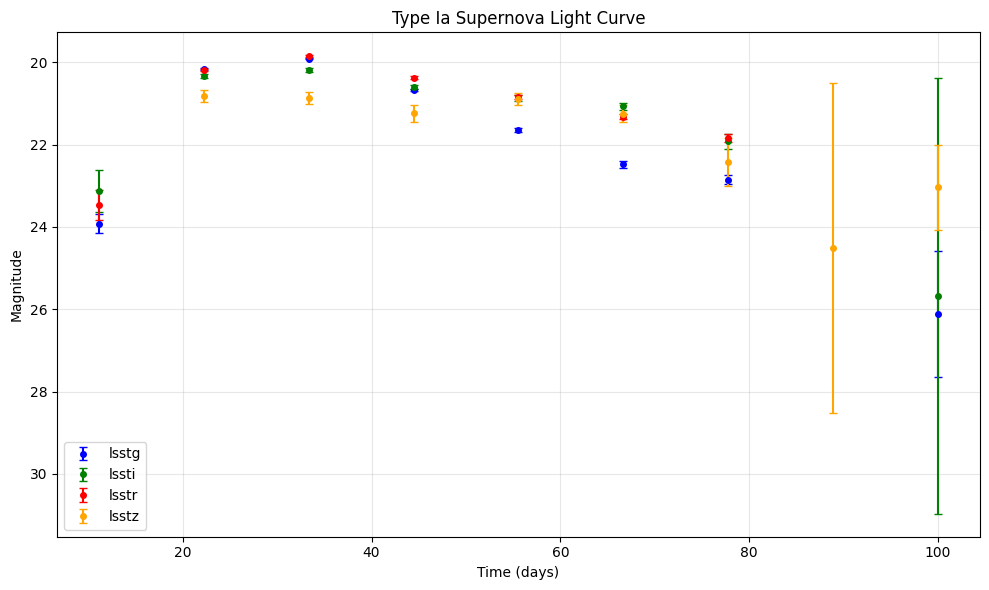

In [18]:
import numpy as np
import sncosmo
from astropy.table import Table
import matplotlib.pyplot as plt

times = np.linspace(0.1,100,100) # days
wavelengths = np.linspace(2000,12000,10) # Angstroms

num_points = 10
time_points = np.linspace(0.01,100, num_points) # to observe
num_points = len(time_points)

bands = ['lsstg', 'lsstr', 'lssti', 'lsstz']

# zeropoints from https://smtn-002.lsst.io/
zeropoints = [28.51, 28.36, 28.17, 27.78]
# LSST sky brightness in mag/arcsec^2 (from SMTN-002 official values)
sky_brightness_mag = [22.25, 21.2, 20.46, 19.61]  # g, r, i, z bands

# LSST observing parameters (from official LSST specs)
exptime = 30.0  # seconds per visit (2x15s exposures)
pixel_scale = 0.2  # arcseconds per pixel (LSST camera)
aperture_radius = 1.0  # arcseconds (typical PSF aperture, will be calculated properly)
read_noise = 8.8  # electrons per pixel per exposure
dark_current = 0.2  # electrons per pixel per second
num_bands = len(bands)

# Convert sky brightness to sky noise (electrons/pixel/second)
# Using LSST effective area = 6.423m diameter, pixel scale = 0.2 arcsec/pixel
# Sky noise = sky_flux * effective_area * pixel_area / exposure_time
# For now, using approximate values - these should be calculated more precisely
sky_noise = 10**(-0.4*(np.asarray(sky_brightness_mag) - np.asarray(zeropoints))) * pixel_scale**2  # g, r, i, z bands (electrons/pixel/second)


ia_obs = Table({'time': list(time_points) * num_bands,
             'band': np.repeat(bands, num_points),
            'zp': np.repeat(zeropoints, num_points), 'zpsys':['ab']*num_points*num_bands, 
             'gain':np.ones(num_points*num_bands), 'skynoise':np.repeat(sky_noise, num_points),
             'exptime': exptime * np.ones(num_points*num_bands),
             'pixel_scale': pixel_scale * np.ones(num_points*num_bands),
             'aperture_radius': aperture_radius * np.ones(num_points*num_bands),
             'read_noise': read_noise * np.ones(num_points*num_bands),
             'dark_current': dark_current * np.ones(num_points*num_bands)})

def get_x0(mb):
    return 10**(-(mb-10.635)/2.5)

def simulate_ia(true_z, t0, x0, x1, c):
    params = {'z': true_z, 't0': t0, 'x0':x0, 'x1': x1, 'c':c}
    
    ia_source = sncosmo.get_source('salt2', version='B22')
    
    this_ia_model = sncosmo.Model(source=ia_source)

    lcs = sncosmo.realize_lcs(ia_obs, this_ia_model, [params])
    r_band_mask = lcs[0]['band'] == 'lsstr'
    snr = np.mean(np.abs(lcs[0]["flux"][r_band_mask]) / lcs[0]["fluxerr"][r_band_mask])
    print("SNR:", snr)

    return lcs

def fit_ia(true_z, lcs):    
    ia_source = sncosmo.get_source('salt2', version='B22')
    
    this_ia_model = sncosmo.Model(source=ia_source)
    
    this_ia_model.set(z = true_z)
    
    result, fitted_model = sncosmo.fit_lc(lcs[0], this_ia_model,
    ['t0', 'x0', 'x1', 'c'], minsnr = 1., guess_z = False, bounds={'x0':(0, 0.1), 'x1':(-3, 2), 'c':(-1, 1)})
    
    return result, fitted_model

def plot_light_curve(lc):
    """
    Plot the light curve in different bands
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Get unique bands
    bands = np.unique(lc['band'])
    colors = ['blue', 'green', 'red', 'orange']
    
    for i, band in enumerate(bands):
        mask = lc['band'] == band
        time = lc['time'][mask]
        flux = lc['flux'][mask]
        fluxerr = lc['fluxerr'][mask]
        
        # Convert flux to magnitude
        mag = -2.5 * np.log10(flux) + lc['zp'][mask]
        magerr = np.abs(2.5 / np.log(10) * fluxerr / flux)
        
        ax.errorbar(time, mag, yerr=magerr, fmt='o', 
                   label=f'{band}', color=colors[i % len(colors)], 
                   capsize=3, markersize=4)
    
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Magnitude')
    ax.set_title('Type Ia Supernova Light Curve')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.invert_yaxis()  # Brighter objects have lower magnitudes
    
    plt.tight_layout()
    plt.show()

def main():
    """
    Main function to simulate a Type Ia supernova and fit its light curve
    """
    # Define supernova parameters
    true_z = 0.1  # redshift
    t0 = 30.0      # time of maximum brightness
    mb = 20.0    # absolute B-band magnitude
    x0 = get_x0(mb)  # amplitude parameter
    x1 = 0.5      # stretch parameter
    c = 0.0       # color parameter
    print(x0)
    
    print(f"Simulating Type Ia supernova with:")
    print(f"  Redshift (z): {true_z}")
    print(f"  Absolute B magnitude: {mb}")
    print(f"  Stretch (x1): {x1}")
    print(f"  Color (c): {c}")
    print(f"  Amplitude (x0): {x0:.6f}")
    print()
    
    # Simulate the light curve
    print("Simulating light curve...")
    lcs = simulate_ia(true_z, t0, x0, x1, c)
    
    # Plot the light curve
    print("Plotting light curve...")
    plot_light_curve(lcs[0])
    
    return lcs

if __name__ == "__main__":
    lcs = main()

0.00017947336268325266
Simulating Type Ia supernova with:
  Redshift (z): 0.1
  Absolute B magnitude: 20.0
  Stretch (x1): 0.5
  Color (c): 0.0
  Amplitude (x0): 0.000179

Simulating light curve...
SNR: 16.400036690280416
Plotting light curve...


/var/folders/0r/_1bnthz146q2xj0c42f4nl_80000gq/T/ipykernel_40211/3792760410.py:91: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + lc['zp'][mask]


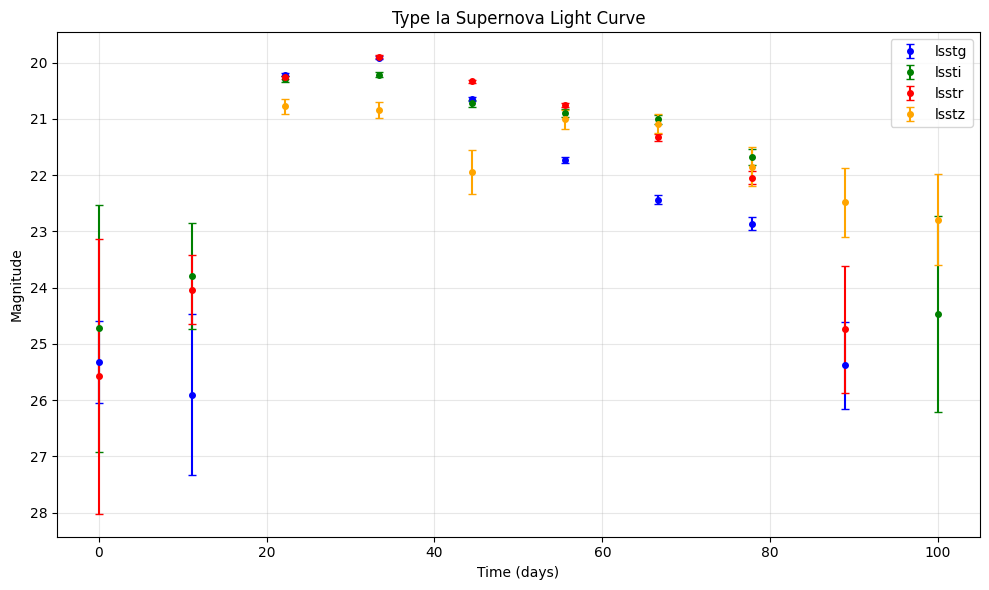

In [19]:
lcs = main()

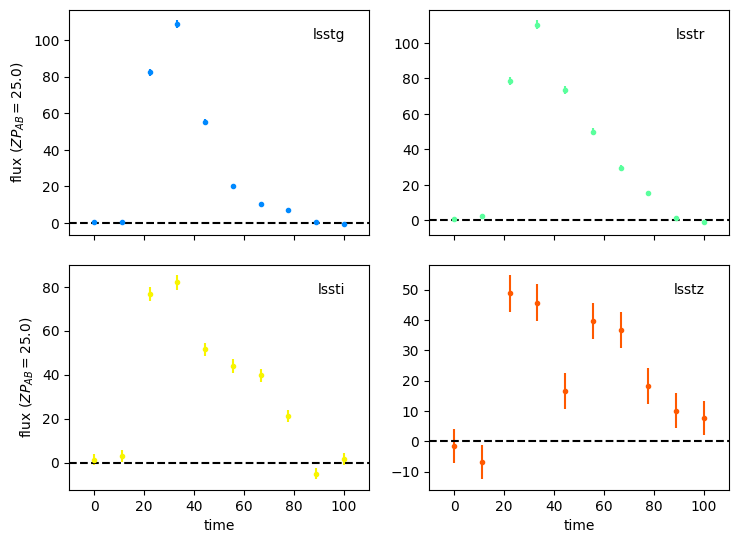

In [20]:
sncosmo.plot_lc(lcs[0]);

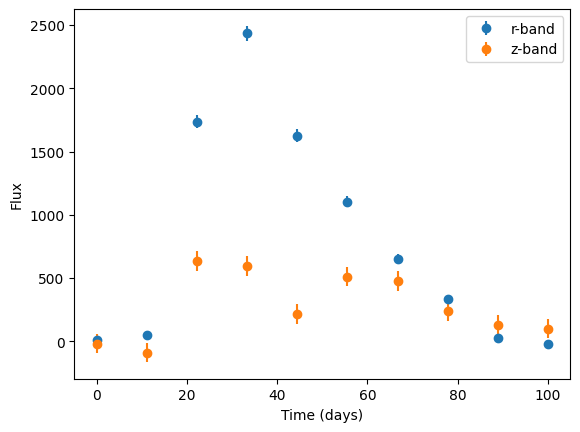

In [21]:
r_band_mask = lcs[0]['band'] == 'lsstr'
z_band_mask = lcs[0]['band'] == 'lsstz'


plt.errorbar(lcs[0]['time'][r_band_mask], lcs[0]['flux'][r_band_mask], yerr=lcs[0]['fluxerr'][r_band_mask], fmt='o', label='r-band')
plt.errorbar(lcs[0]['time'][z_band_mask], lcs[0]['flux'][z_band_mask], yerr=lcs[0]['fluxerr'][z_band_mask], fmt='o', label='z-band')
plt.xlabel('Time (days)')
plt.ylabel('Flux')
plt.legend()
plt.show()

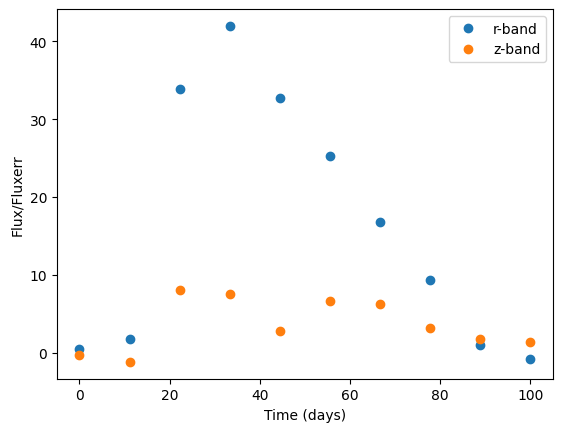

In [23]:
plt.errorbar(lcs[0]['time'][r_band_mask], lcs[0]['flux'][r_band_mask]/lcs[0]['fluxerr'][r_band_mask], fmt='o', label='r-band')
plt.errorbar(lcs[0]['time'][z_band_mask], lcs[0]['flux'][z_band_mask]/lcs[0]['fluxerr'][z_band_mask], fmt='o', label='z-band')
plt.xlabel('Time (days)')
plt.ylabel('Flux/Fluxerr')
plt.legend()
plt.show()

In [126]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from sklearn.mixture import GaussianMixture


rng = np.random.default_rng()

In [127]:
class SN:
    ia_keys = ['z', 't0', 'x0', 'x1', 'c']
    ibc_keys = ['z', 'texp', 'mej', 'fni', 'vej', 'log_vej']
    ia_fit = {key:None for key in ia_keys}
    ibc_fit = {key:None for key in ibc_keys}
    
    def __init__(self, true_class, true_dict):
        self.true_class = true_class
        if self.true_class == 'ia':
            self.true_params = {key:true_dict[key] for key in self.ia_keys}
        elif self.true_class == 'ibc':
            self.true_params = {key:true_dict[key] for key in self.ibc_keys}
        else:
            raise ValueError("SN has to be either ia or ibc")
            
    def fit_as_ia(self, results_dict):
        self.ia_fit = {key:results_dict[key] for key in self.ia_keys[1:]}
    
    def fit_as_ibc(self, results_dict):
        self.ibc_fit = {key:results_dict[key] for key in self.ibc_keys[1:]}
        self.ibc_fit.update({'log_vej': np.log10(self.ibc_fit['vej'])})

In [128]:
data = np.load("fitted_sne_100_100125.npz", allow_pickle=True)
true_ia_sne = data['ia']
true_ibc_sne = data['ibc']
all_sne = np.concatenate((true_ia_sne, true_ibc_sne))
len(true_ibc_sne), len(all_sne)


(100, 200)

In [129]:
for sn in all_sne:
    sn.ibc_fit.update({'log_vej': np.log10(sn.ibc_fit['vej'])})

In [130]:
all_sne

array([<__main__.SN object at 0x15c5d06d0>,
       <__main__.SN object at 0x163cec4c0>], dtype=object)

In [131]:
all_sne[100].true_class

'ibc'

In [132]:
[all_sne[i].true_params for i in range(101,110)]

[{'z': 0.207,
  'texp': 4.653310749750714,
  'mej': 5.9561,
  'fni': 0.0844,
  'vej': 6245.3795873919},
 {'z': 0.175,
  'texp': 6.535975581128358,
  'mej': 6.2457,
  'fni': 0.0856,
  'vej': 10013.272631574178},
 {'z': 0.268,
  'texp': 6.8488839740127565,
  'mej': 9.8593,
  'fni': 0.145,
  'vej': 9184.71104631547},
 {'z': 0.276,
  'texp': 2.3954212249242888,
  'mej': 7.5367,
  'fni': 0.1377,
  'vej': 7416.411383180844},
 {'z': 0.192,
  'texp': 2.633729485026253,
  'mej': 4.7711,
  'fni': 0.1039,
  'vej': 11776.231098083292},
 {'z': 0.105,
  'texp': 1.4747784397850816,
  'mej': 6.1382,
  'fni': 0.0252,
  'vej': 10823.865766773122},
 {'z': 0.19,
  'texp': 0.11683135998292349,
  'mej': 4.5871,
  'fni': 0.0931,
  'vej': 8095.727773637579},
 {'z': 0.198,
  'texp': 4.06792064309589,
  'mej': 7.4094,
  'fni': 0.0987,
  'vej': 5542.223181955493},
 {'z': 0.23,
  'texp': 6.650348035687384,
  'mej': 7.0326,
  'fni': 0.1026,
  'vej': 10690.863926169728}]

In [133]:
for sn in all_sne:
    sn.ibc_fit.update({'log_vej': np.log10(sn.ibc_fit['vej'])})

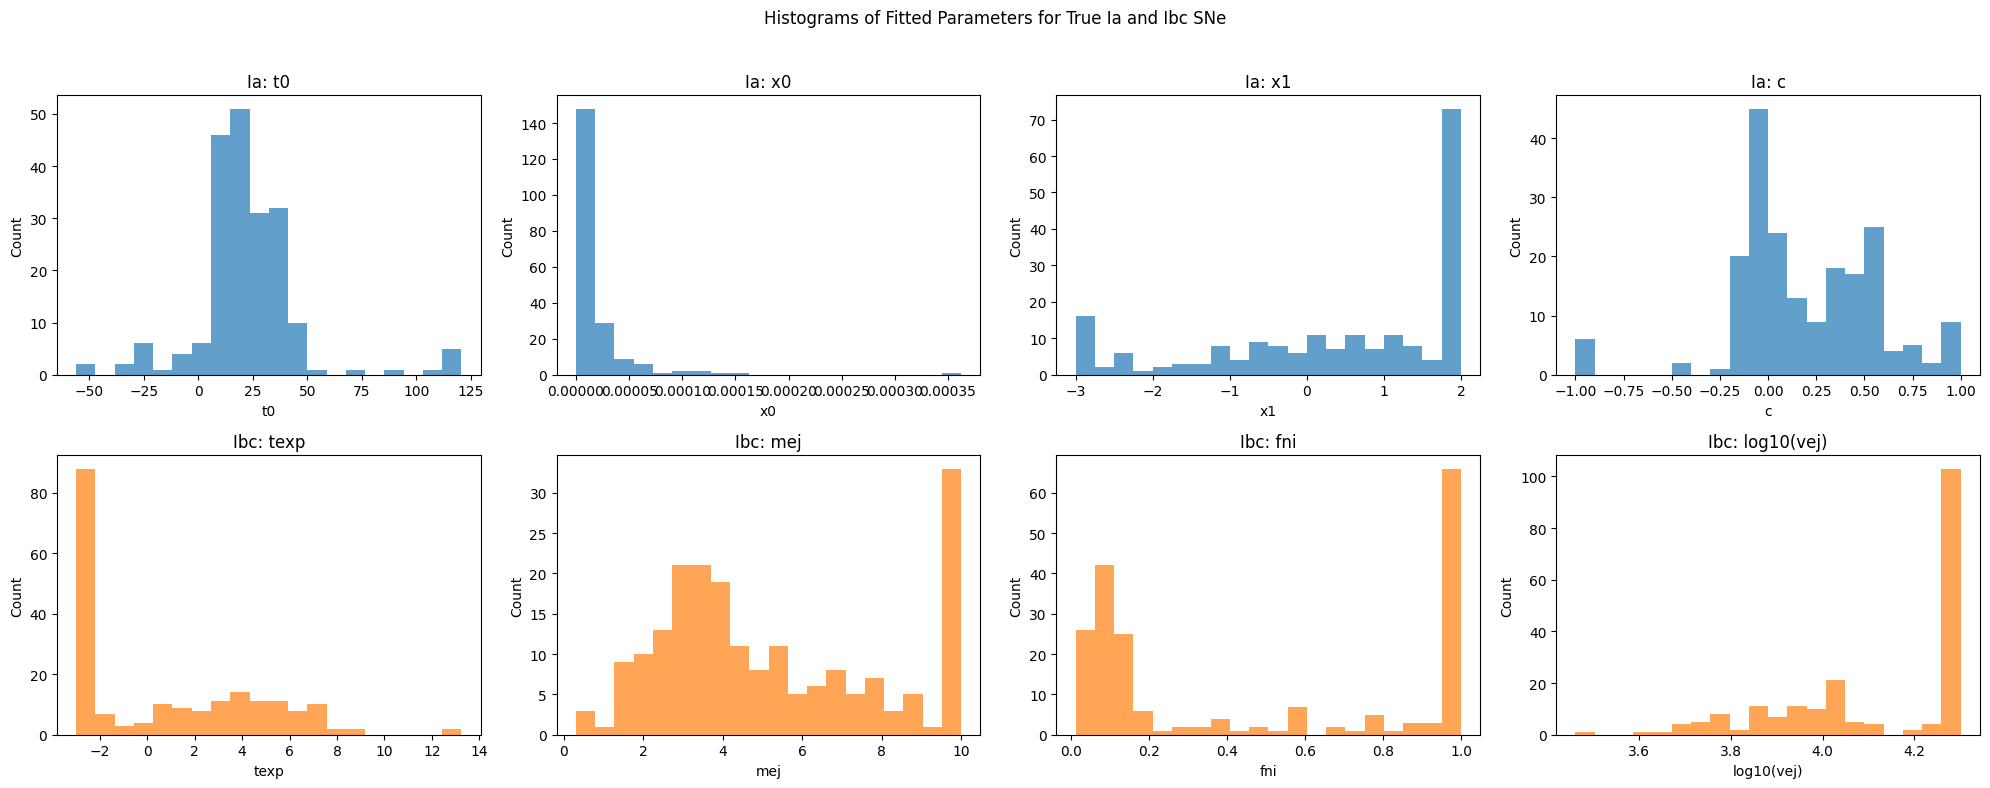

In [134]:
ia_param_names = SN.ia_keys[1:]  # ['t0', 'x0', 'x1', 'c']
ibc_param_names = SN.ibc_keys[1:]  # ['texp', 'mej', 'fni', 'vej']

fig, axes = plt.subplots(2, 4, figsize=(20, 8))
fig.suptitle("Histograms of Fitted Parameters for True Ia and Ibc SNe")

# Plot Ia fitted parameters
for i, param in enumerate(ia_param_names):
    values = [sn.ia_fit[param] for sn in all_sne if sn.ia_fit[param] is not None]
    axes[0, i].hist(values, bins=20, color='tab:blue', alpha=0.7)
    axes[0, i].set_title(f"Ia: {param}")
    axes[0, i].set_xlabel(param)
    axes[0, i].set_ylabel("Count")

# Plot Ibc fitted parameters
for i, param in enumerate(ibc_param_names[:4]):
    values = [sn.ibc_fit[param] for sn in all_sne if sn.ibc_fit[param] is not None]
    if param == 'vej':
        # Plot log10 for vej
        values = [np.log10(v) for v in values if v > 0]
        axes[1, i].hist(values, bins=20, color='tab:orange', alpha=0.7)
        axes[1, i].set_title(f"Ibc: log10({param})")
        axes[1, i].set_xlabel(f"log10({param})")
    else:
        axes[1, i].hist(values, bins=20, color='tab:orange', alpha=0.7)
        axes[1, i].set_title(f"Ibc: {param}")
        axes[1, i].set_xlabel(param)
    axes[1, i].set_ylabel("Count")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

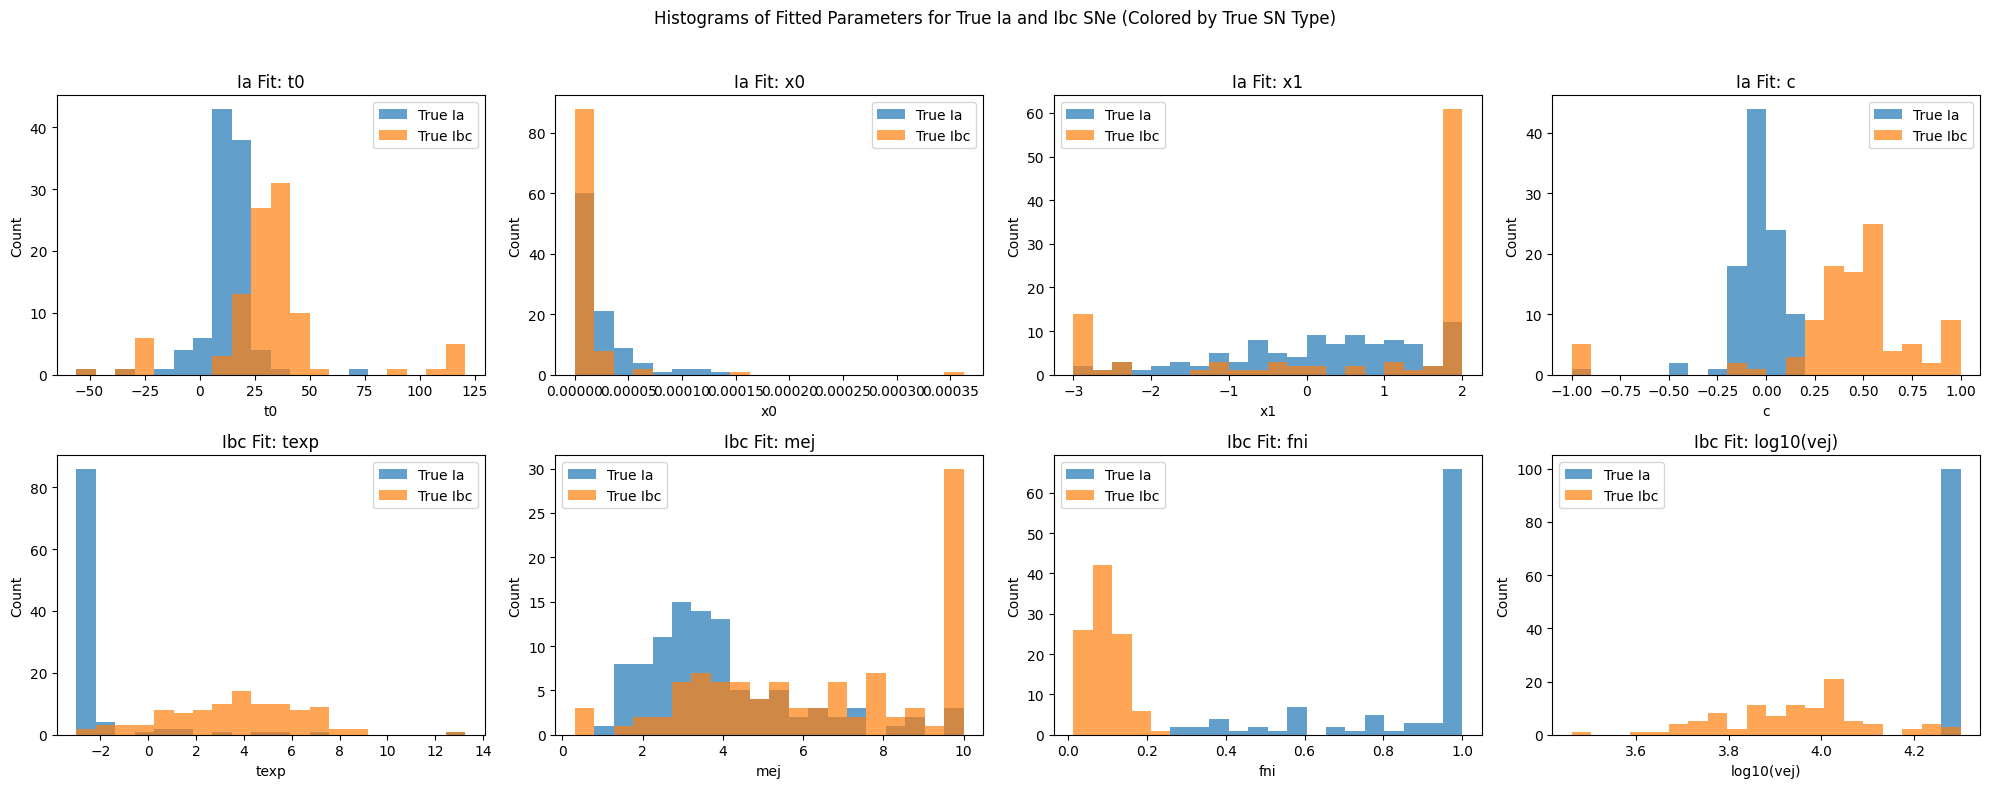

In [135]:
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
fig.suptitle("Histograms of Fitted Parameters for True Ia and Ibc SNe (Colored by True SN Type)")

# Plot Ia fitted parameters
for i, param in enumerate(ia_param_names):
    ia_values = [sn.ia_fit[param] for sn in true_ia_sne if sn.ia_fit[param] is not None]
    ibc_values = [sn.ia_fit[param] for sn in true_ibc_sne if sn.ia_fit[param] is not None]
    all_values = ia_values + ibc_values
    bins = np.histogram_bin_edges(all_values, bins=20)
    axes[0, i].hist(ia_values, bins=bins, color='tab:blue', alpha=0.7, label='True Ia')
    axes[0, i].hist(ibc_values, bins=bins, color='tab:orange', alpha=0.7, label='True Ibc')
    axes[0, i].set_title(f"Ia Fit: {param}")
    axes[0, i].set_xlabel(param)
    axes[0, i].set_ylabel("Count")
    axes[0, i].legend()

# Plot Ibc fitted parameters
for i, param in enumerate(ibc_param_names[:4]):
    ia_values = [sn.ibc_fit[param] for sn in true_ia_sne if sn.ibc_fit[param] is not None]
    ibc_values = [sn.ibc_fit[param] for sn in true_ibc_sne if sn.ibc_fit[param] is not None]
    if param == 'vej':
        ia_values = [np.log10(v) for v in ia_values if v > 0]
        ibc_values = [np.log10(v) for v in ibc_values if v > 0]
    all_values = ia_values + ibc_values
    bins = np.histogram_bin_edges(all_values, bins=20)
    axes[1, i].hist(ia_values, bins=bins, color='tab:blue', alpha=0.7, label='True Ia')
    axes[1, i].hist(ibc_values, bins=bins, color='tab:orange', alpha=0.7, label='True Ibc')
    if param == 'vej':
        axes[1, i].set_title(f"Ibc Fit: log10({param})")
        axes[1, i].set_xlabel(f"log10({param})")
    else:
        axes[1, i].set_title(f"Ibc Fit: {param}")
        axes[1, i].set_xlabel(param)
    axes[1, i].set_ylabel("Count")
    axes[1, i].legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Here we have 8 parameters that we can use to constrain the mixing fraction

In [136]:
# This is the log likelihood function for the distribution of one parameter 
# assuming a mixture of two Gaussians.
# x is the parameter value, samples are the observed data, and alpha is the mixing fraction
def log_likelihood(x, samples, alpha):
    mu1, sigma1, mu2, sigma2 = x
    first_term = alpha * norm.pdf(samples, mu1, sigma1)
    second_term = (1 - alpha) * norm.pdf(samples, mu2, sigma2)
    return np.sum(np.log(first_term + second_term))

In [137]:
def get_param_samples(param_name):
    if param_name in ia_param_names:
        return np.array([sn.ia_fit[param_name] for sn in all_sne])
    elif param_name in ibc_param_names:
        return np.array([sn.ibc_fit[param_name] for sn in all_sne])
    else:
        raise ValueError(f"Parameter {param_name} not recognized in either Ia or Ibc SNe.")

(array([177.,  15.,   3.,   3.,   1.,   0.,   0.,   0.,   0.,   1.]),
 array([6.55947464e-15, 3.62439056e-05, 7.24878112e-05, 1.08731717e-04,
        1.44975622e-04, 1.81219528e-04, 2.17463434e-04, 2.53707339e-04,
        2.89951245e-04, 3.26195150e-04, 3.62439056e-04]),
 <BarContainer object of 10 artists>)

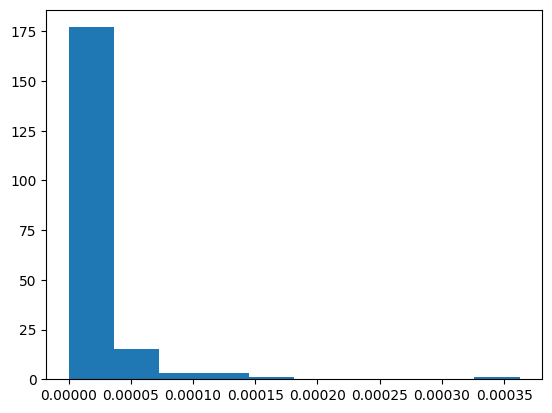

In [138]:
plt.hist(get_param_samples('x0'))

In [139]:
np.shape(get_param_samples('log_vej').reshape(-1, 1))

(200, 1)

In [140]:
# Fit initial guesses
params_to_use = ['t0', 'c', 'mej', 'texp', 'x1', 'x0', 'fni', 'log_vej']

mus_a = {}
mus_b = {}
sigmas_a = {}
sigmas_b = {}

for param_name in params_to_use:
    samples = get_param_samples(param_name).reshape(-1, 1)
    gm = GaussianMixture(n_components=2).fit(samples)
    mus_a[param_name] = gm.means_[0][0]
    mus_b[param_name] = gm.means_[1][0]
    sigmas_a[param_name] = np.sqrt(gm.covariances_[0][0][0])
    sigmas_b[param_name] = np.sqrt(gm.covariances_[1][0][0])
    print(param_name, gm.weights_)

t0 [0.96380452 0.03619548]
c [0.69049636 0.30950364]
mej [0.66959223 0.33040777]
texp [0.42998141 0.57001859]
x1 [0.66992068 0.33007932]
x0 [0.03457864 0.96542136]
fni [0.50352162 0.49647838]
log_vej [0.50476897 0.49523103]


In [141]:
# from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=2).fit(get_param_samples('x1').reshape(-1, 1))
gm.means_, gm.covariances_**0.5, gm.weights_

(array([[ 1.99997582],
        [-0.33449371]]),
 array([[[1.01512963e-03]],
 
        [[1.48523512e+00]]]),
 array([0.33007932, 0.66992068]))

In [142]:
num_epochs = 200
lls = np.zeros(num_epochs)


# mus_a = {'t0': 20, 'x0': 0.0001, 'x1': 2, 'c': 0, 'texp': 0.5, 'mej': 8, 'fni': 0.05, 'log_vej': 4.3}
# mus_b = {'t0': 20, 'x0': 0.0001, 'x1': 0.5, 'c': 0.6, 'texp': 5, 'mej': 2, 'fni': 0.49, 'log_vej': 3.9}
# sigmas_a = {'t0': 10, 'x0': 5e-4, 'x1': 0.01, 'c': 0.1, 'texp': 0.2, 'mej': 2, 'fni': 0.01, 'log_vej': 0.05}
# sigmas_b = {'t0': 10, 'x0': 5e-4, 'x1': 1, 'c': 0.3, 'texp': 3, 'mej': 2, 'fni': 5e-2, 'log_vej': 0.2}


alphas = np.zeros(num_epochs)  # Store alpha values for each epoch
alpha = 0.1  # Mixing fraction
gammas_a = {'texp': [], 'mej': [], 'fni': [], 'log_vej': [], 't0': [], 'x0': [], 'x1': [], 'c': []}
gammas_b = {'texp': [], 'mej': [], 'fni': [], 'log_vej': [], 't0': [], 'x0': [], 'x1': [], 'c': []}

params_to_use = ['t0', 'c', 'mej', 'texp', 'x1', 'x0', 'fni', 'log_vej']
# params_to_use = list(mus_a.keys())  # Use all parameters for fitting



# there are two populations, a and b
for epoch in range(num_epochs):
    # for param_name in list(mus_a.keys())[:3]:
    for param_name in params_to_use:
        param_samples = get_param_samples(param_name)

        # plt.hist(param_samples)
        # plt.show()

        # print(mus_a[param_name], sigmas_a[param_name])
        # the gammas are weights for every sample
        gammas_a[param_name] = alpha * norm.pdf(param_samples, mus_a[param_name], sigmas_a[param_name])
        gammas_b[param_name] = (1 - alpha) * norm.pdf(param_samples, mus_b[param_name], sigmas_b[param_name])
        
        # print(param_name)
        # print(np.sum(gammas_a[param_name]), np.sum(gammas_b[param_name]))
        # print(sum(np.isnan(gammas_a[param_name])), sum(np.isinf(gammas_a[param_name])))

        # Normalize over parameter
        gamma_total = (gammas_a[param_name] + gammas_b[param_name])
        gammas_a[param_name] /= gamma_total
        gammas_b[param_name] /= gamma_total
        

        mus_a[param_name] = np.sum(gammas_a[param_name] * param_samples) / np.sum(gammas_a[param_name])
        mus_b[param_name] = np.sum(gammas_b[param_name] * param_samples) / np.sum(gammas_b[param_name])
        sigmas_a[param_name] = np.sqrt(np.sum(gammas_a[param_name] * (param_samples - mus_a[param_name])**2) / np.sum(gammas_a[param_name]))
        sigmas_b[param_name] = np.sqrt(np.sum(gammas_b[param_name] * (param_samples - mus_b[param_name])**2) / np.sum(gammas_b[param_name]))

    
    # Here we can use information from all parameters to constrain the mixing fraction
    # alpha is the fraction of parameter a, parameter b has 1 - alpha
    alpha = np.mean(np.concatenate([gammas_a[param_name] for param_name in params_to_use]))
    alphas[epoch] = alpha
    print("Alpha", alpha)

    # Calculate log likelihood for the current epoch
    for param_name in params_to_use:
        lls[epoch] += log_likelihood([mus_a[param_name], sigmas_a[param_name], mus_b[param_name], sigmas_b[param_name]], get_param_samples(param_name), alpha)

    

Alpha 0.4924535084177461
Alpha 0.567783737833649
Alpha 0.5948268323119635
Alpha 0.6051327752975115
Alpha 0.6099134622538003
Alpha 0.6121025408179235
Alpha 0.6054178465873373
Alpha 0.5862019509709193
Alpha 0.5745037617995332
Alpha 0.5708369629963252
Alpha 0.5707744036003766
Alpha 0.571302840894354
Alpha 0.571672770076932
Alpha 0.5718302818374233
Alpha 0.5718421315817036
Alpha 0.5717660626732076
Alpha 0.5716362410033545
Alpha 0.571470979139764
Alpha 0.5712926827666558
Alpha 0.5711546151412519
Alpha 0.5710951030779877
Alpha 0.5710997382399668
Alpha 0.5711502885303312
Alpha 0.5712371577596904
Alpha 0.5713548589068951
Alpha 0.5714999220953539
Alpha 0.5716704729500018
Alpha 0.5718662307886855
Alpha 0.572088594874426
Alpha 0.5723408040957058
Alpha 0.5726282146481271
Alpha 0.5729587256155654
Alpha 0.5733433186947446
Alpha 0.5737964926148647
Alpha 0.5743358662307816
Alpha 0.5749790582917954
Alpha 0.5757342350048166
Alpha 0.5765818029409027
Alpha 0.5774558856445392
Alpha 0.578251517385295
Alpha 

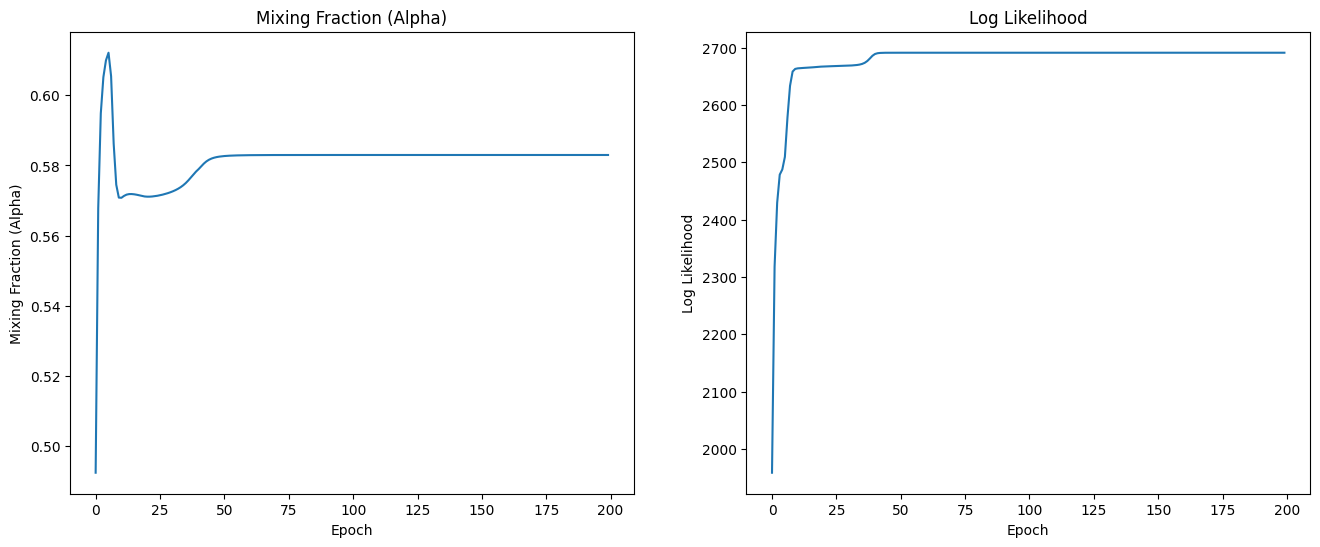

In [143]:
fig, ax = plt.subplots(1,2, figsize=(16, 6))
ax[0].plot(alphas)
ax[1].plot(lls)
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Mixing Fraction (Alpha)")
ax[0].set_title("Mixing Fraction (Alpha)")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Log Likelihood")
ax[1].set_title("Log Likelihood")

plt.show()

In [144]:
mus_a, mus_b, sigmas_a, sigmas_b

({'t0': 18.829054142858453,
  'c': 0.31809143839446546,
  'mej': 3.3583753710628597,
  'texp': -2.9999990545918105,
  'x1': -0.2788794668893033,
  'x0': 4.159022851857977e-05,
  'fni': 0.8628703367219493,
  'log_vej': 4.30102992994758},
 {'t0': 107.84590311082532,
  'c': -0.05021486720533178,
  'mej': 8.366611100874572,
  'texp': 3.4390927891485483,
  'x1': 1.9999977199852859,
  'x0': 1.154153916264714e-05,
  'fni': 0.09051636375281821,
  'log_vej': 3.9572899412495066},
 {'t0': 17.043231103559904,
  'c': 0.4225308347140032,
  'mej': 1.2163711702237276,
  'texp': 1.7494843966014066e-06,
  'x1': 1.5099915559119703,
  'x0': 5.140869106021019e-05,
  'fni': 0.22374729149700787,
  'log_vej': 1.1113204803340924e-07},
 {'t0': 15.308707039239621,
  'c': 0.0672050643502408,
  'mej': 1.6792306762864622,
  'texp': 3.0626101133084056,
  'x1': 5.197094065974689e-06,
  'x0': 3.4956520646960053e-06,
  'fni': 0.04232103179971808,
  'log_vej': 0.16778207751856855})

In [145]:
for n in sigmas_b.keys():
    if sigmas_b[n] <= 0.01:
        sigmas_b[n] = 0.01

for n in sigmas_a.keys():
    if sigmas_a[n] <= 0.01:
        sigmas_a[n] = 0.01

In [161]:
sigmas_a['x0'] = 1e-5
sigmas_b['x0'] = 1e-6

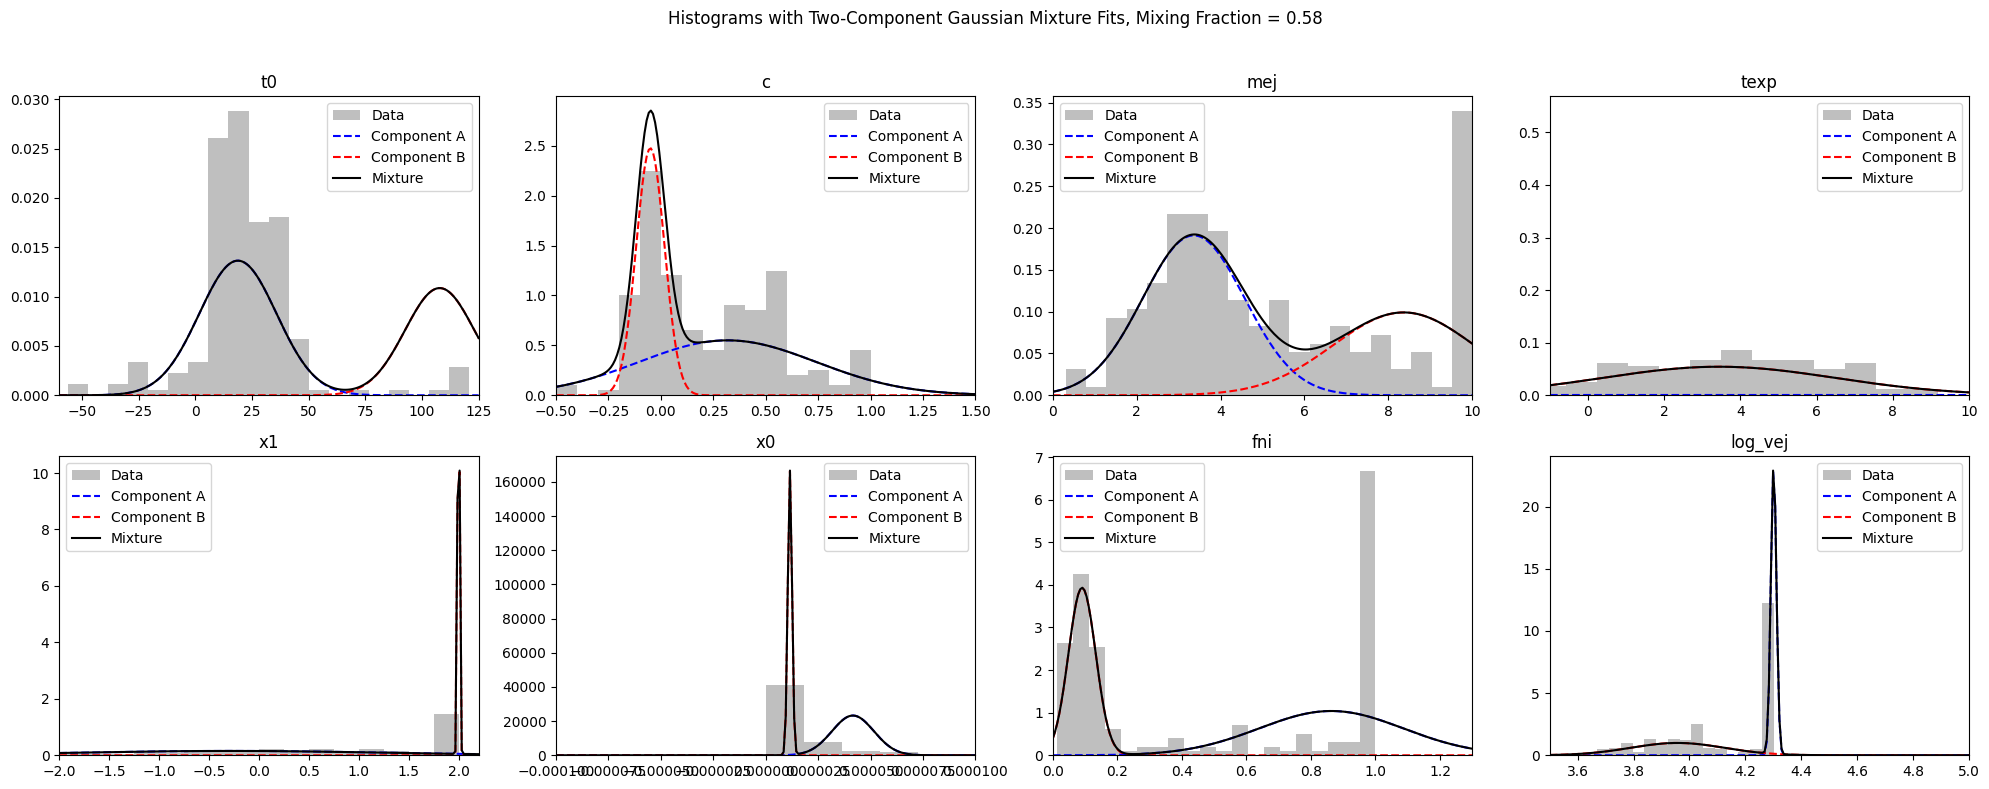

In [162]:
x_ranges = {
    't0': np.linspace(-60, 125, 200),
    'x0': np.linspace(-0.0001, 0.0001, 200),  # Expanded range for x0
    'x1': np.linspace(-2, 2.2, 200),
    'c': np.linspace(-0.5, 1.5, 200),
    'texp': np.linspace(-1, 10, 200),
    'mej': np.linspace(0, 10, 200),
    'fni': np.linspace(0, 1.3, 200),
    'log_vej': np.linspace(3.5, 5, 200)
}

fig, axes = plt.subplots(2, 4, figsize=(20, 8))
fig.suptitle("Histograms with Two-Component Gaussian Mixture Fits, Mixing Fraction = {:.2f}".format(alpha))

for idx, param in enumerate(params_to_use):
    samples = get_param_samples(param)
    ax = axes.flat[idx]
    ax.hist(samples, bins=20, density=True, alpha=0.5, color='gray', label='Data')
    x = x_ranges[param]
    # Mixture fit
    y_a = alpha * norm.pdf(x, mus_a[param], sigmas_a[param])
    y_b = (1 - alpha) * norm.pdf(x, mus_b[param], sigmas_b[param])
    y_mix = y_a + y_b
    ax.plot(x, y_a, 'b--', label='Component A')
    ax.plot(x, y_b, 'r--', label='Component B')
    ax.plot(x, y_mix, 'k-', label='Mixture')
    ax.set_title(param)
    ax.set_xlim(x[0], x[-1])  # Ensure curves span the full x range
    # if param == 'texp':
    #     ax.set_ylim(0, 1)
    # elif param == 'fni':
    #     ax.set_ylim(0, 10)
    #     ax.set_xlim(0, 1.1)
    # elif param == 'x0':
    #     ax.set_ylim(0, 500)
    #     ax.set_xlim(-0.001, 0.001)  # Expanded
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

(array([  1.,   0.,   0.,   0.,   0.,   0.,   1.,   2., 165.,  31.]),
 array([-14.18313094, -13.10889435, -12.03465776, -10.96042116,
         -9.88618457,  -8.81194798,  -7.73771138,  -6.66347479,
         -5.5892382 ,  -4.5150016 ,  -3.44076501]),
 <BarContainer object of 10 artists>)

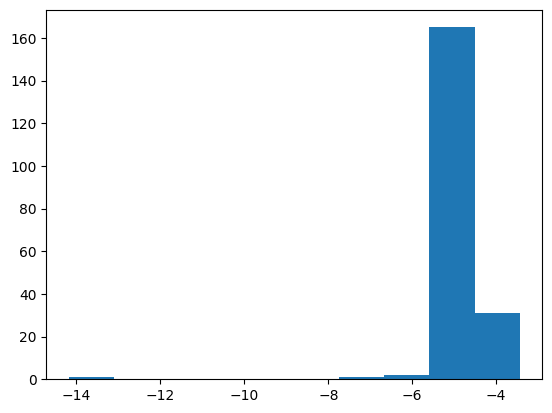

In [154]:
plt.hist(np.log10(get_param_samples('x0')))

In [155]:
get_param_samples('x0')

array([2.29175046e-05, 4.47174844e-05, 1.27162028e-05, 1.78497059e-05,
       1.37480002e-05, 1.39162698e-05, 1.39760034e-05, 1.90511901e-05,
       8.65477109e-06, 2.35432296e-05, 1.30908030e-05, 1.20955834e-05,
       1.16763841e-05, 4.49306214e-05, 3.04682316e-05, 1.09723283e-05,
       1.40211670e-05, 1.09248781e-05, 1.02320497e-05, 1.52739709e-05,
       1.07872697e-05, 7.05543275e-08, 1.02717222e-05, 2.15515120e-05,
       1.65873671e-05, 8.01391739e-05, 6.46818526e-05, 1.55935753e-05,
       1.73155780e-05, 1.17494897e-05, 1.37160391e-05, 1.04864824e-04,
       1.17010127e-05, 2.04189730e-05, 3.48955045e-05, 3.94973962e-05,
       5.33059513e-05, 3.51238938e-05, 3.68102389e-05, 1.26873869e-05,
       2.07297350e-05, 1.04396077e-05, 6.61781153e-05, 9.13271743e-06,
       8.57952294e-06, 8.59813861e-06, 1.03927113e-05, 1.40084326e-05,
       7.64652339e-06, 1.32285207e-05, 1.20308260e-05, 1.38298686e-05,
       9.80667342e-06, 1.93039781e-05, 1.00593737e-04, 9.32268554e-06,
      